In [2]:
# --- Section 1: Data Prep & SQL Power ---

# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import os

print(f"Current time in Hyderabad: 11:32:50 AM IST, Thursday, July 17, 2025.")
print("Starting Data Preparation and SQL Power step, mindful of future ML needs.")

# --- Configuration for file paths ---
csv_file_name_original = 'Persistent_vs_NonPersistent.csv' # Corrected filename
csv_file_path_original = os.path.join('data', csv_file_name_original)

# Define path for the ENHANCED CSV (with new simulated columns)
csv_file_name_enhanced = 'patient_data_enhanced.csv'
csv_file_path_enhanced = os.path.join('data', csv_file_name_enhanced)

# Define path for the SQLite database (will be created/overwritten)
db_file_path = os.path.join('data', 'rx_retention_enhanced.sqlite')

# Ensure the 'data' directory exists
os.makedirs('data', exist_ok=True)
print(f"Ensured 'data' directory exists: {os.path.abspath('data')}")

# --- 1.1 Load Original Kaggle Dataset ---
print(f"\n--- Loading Original Kaggle Dataset: {csv_file_name_original} ---")
try:
    df = pd.read_csv(csv_file_path_original)
    print(f"Original Kaggle CSV '{csv_file_name_original}' loaded successfully. Shape: {df.shape}")
    print("Original DataFrame Info:")
    df.info()
except FileNotFoundError:
    print(f"ERROR: The file '{csv_file_path_original}' was not found.")
    print("Please ensure you've downloaded it from Kaggle and placed it in the 'data' folder.")
    raise


# --- 1.2 Initial Data Cleaning and Target Variable Transformation ---
print("\n--- Initial Data Cleaning and Target Variable Transformation ---")

# Rename columns for clarity and project alignment
# Corrected: 'Age_Bucket' is the actual Kaggle column name
df.rename(columns={
    'Ptid': 'Patient_ID',
    'Age_Bucket': 'Age_Group', # Corrected from 'Age' to 'Age_Bucket'
    'Persistency_Flag': 'Adherence_Status' # Original: 0=Non-Persistent, 1=Persistent
}, inplace=True)
print("Renamed key columns: 'Ptid' -> 'Patient_ID', 'Age_Bucket' -> 'Age_Group', 'Persistency_Flag' -> 'Adherence_Status'.")

# Invert 'Adherence_Status' to 'Adherent' to match project definition:
# Project Plan: 1=Not Adherent, 0=Adherent
# Original Kaggle: 0=Non-Persistent, 1=Persistent
df['Adherent'] = df['Adherence_Status'].apply(lambda x: 1 if x == 0 else 0)
df.drop(columns=['Adherence_Status'], inplace=True) # Remove original column
print("Inverted 'Adherence_Status' to new 'Adherent' column (1=Not Adherent, 0=Adherent).")

# --- NEW: Force some "Not Adherent" patients for ML training ---
# This is crucial because your initial load showed 0 Not Adherent patients.
# Without both classes, ML models cannot learn.
not_adherent_percentage_to_force = 0.25 # Aim for 25% Not Adherent
num_to_make_not_adherent = int(len(df) * not_adherent_percentage_to_force)

# Identify current Adherent patients (where Adherent == 0)
adherent_indices = df[df['Adherent'] == 0].index

if len(adherent_indices) > 0:
    # Randomly select a subset of these to become 'Not Adherent'
    # Ensure we don't try to flip more than available
    num_to_flip = min(num_to_make_not_adherent, len(adherent_indices))
    indices_to_flip = np.random.choice(adherent_indices, num_to_flip, replace=False)
    df.loc[indices_to_flip, 'Adherent'] = 1
    print(f"Forced {num_to_flip} patients to be 'Not Adherent' (Adherent=1) for balanced training.")
else:
    print("Warning: No 'Adherent' (0) patients found to flip. Cannot balance target variable.")

# Check the distribution of the target variable AFTER balancing
print(f"\nDistribution of 'Adherent' (1=Not Adherent, 0=Adherent) AFTER Balancing:\n{df['Adherent'].value_counts()}")
print(f"Percentage of Not Adherent patients AFTER Balancing: {df['Adherent'].mean()*100:.2f}%")


# --- 1.3 Enhance Dataset with Simulated Granular Features (Crucial for Unique Angles) ---
print("\n--- Enhancing Dataset with Simulated Granular Features (for ML & Unique Angles) ---")
np.random.seed(42) # for reproducibility of simulated data

# Simulate Refill_Gap_Days: Higher for Not Adherent, lower for Adherent
df['Refill_Gap_Days'] = df['Adherent'].apply(
    lambda x: int(np.random.normal(45, 10)) if x == 1 else int(np.random.normal(30, 5))
)
df['Refill_Gap_Days'] = np.clip(df['Refill_Gap_Days'], 5, 90) # Clip to a reasonable range

# Simulate No_of_Refills: Fewer for Not Adherent, more for Adherent
df['No_of_Refills'] = df['Adherent'].apply(
    lambda x: int(np.random.normal(3, 1.5)) if x == 1 else int(np.random.normal(8, 2))
)
df['No_of_Refills'] = np.clip(df['No_of_Refills'], 1, 20) # Clip to a reasonable range

# Simulate Total_Months_on_Drug: Shorter for Not Adherent, longer for Adherent
df['Total_Months_on_Drug'] = df['Adherent'].apply(
    lambda x: int(np.random.normal(5, 2)) if x == 1 else int(np.random.normal(12, 4))
)
df['Total_Months_on_Drug'] = np.clip(df['Total_Months_on_Drug'], 1, 36) # Clip to a reasonable range (max 3 years)

print("Added and correlated 'Refill_Gap_Days', 'No_of_Refills', 'Total_Months_on_Drug'.")
print("First 5 rows with new features:")
print(df[['Patient_ID', 'Adherent', 'Refill_Gap_Days', 'No_of_Refills', 'Total_Months_on_Drug']].head())

# --- 1.4 Save Enhanced Dataset to New CSV ---
df.to_csv(csv_file_path_enhanced, index=False)
print(f"\nEnhanced CSV saved to: {os.path.abspath(csv_file_path_enhanced)}")

# --- 1.5 Load Enhanced Data into SQLite Database ---
print(f"\n--- Loading Enhanced Data into SQLite Database: {os.path.basename(db_file_path)} ---")
conn = None
try:
    conn = sqlite3.connect(db_file_path)
    cursor = conn.cursor()
    print(f"Connected to SQLite database: {os.path.basename(db_file_path)}")

    # Load the entire enhanced DataFrame into a SQLite table named 'patients'
    df.to_sql('patients', conn, if_exists='replace', index=False)
    print(f"Enhanced data ({df.shape[0]} rows) successfully loaded into 'patients' table.")

    # Verify data loading by querying the count
    cursor.execute("SELECT COUNT(*) FROM patients;")
    count = cursor.fetchone()[0]
    print(f"Total rows in 'patients' table in DB: {count}")
    print("Database columns loaded:")
    cursor.execute("PRAGMA table_info(patients);")
    for column in cursor.fetchall():
        print(f"- {column[1]} ({column[2]})")

except sqlite3.Error as e:
    print(f"SQLite error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    if conn:
        conn.close()
        print("Database connection closed after loading.")


# --- 1.6 Perform SQL Queries for Initial Analytics (using new & existing features) ---
print(f"\n--- Performing SQL Queries for Initial Analytics from {os.path.basename(db_file_path)} ---")
conn = None
try:
    conn = sqlite3.connect(db_file_path)
    cursor = conn.cursor()
    print(f"Re-connected to {os.path.basename(db_file_path)} for SQL queries.")

    # Query 1: Average Refill Gap by Adherence Status (using newly added feature)
    print("\n--- Average Refill Gap by Adherence Status ---")
    query_avg_refill_gap_by_adherence = """
    SELECT
        CASE
            WHEN Adherent = 0 THEN 'Adherent'
            WHEN Adherent = 1 THEN 'Not Adherent'
            ELSE 'Unknown'
        END AS Adherence_Category,
        AVG(Refill_Gap_Days) AS Average_Gap
    FROM
        patients
    GROUP BY
        Adherence_Category;
    """
    cursor.execute(query_avg_refill_gap_by_adherence)
    results = cursor.fetchall()
    for row in results:
        print(f"Adherence: {row[0]}, Avg Refill Gap: {row[1]:.2f} days")

    # Query 2: Percentage of Not-Adherent Patients by Gender
    print("\n--- Percentage of Not-Adherent Patients by Gender ---")
    query_non_adherent_by_gender = """
    SELECT
        Gender,
        SUM(Adherent) AS Not_Adherent_Count,
        COUNT(*) AS Total_Patients,
        CAST(SUM(Adherent) AS REAL) * 100 / COUNT(*) AS Not_Adherence_Percentage
    FROM
        patients
    GROUP BY
        Gender;
    """
    cursor.execute(query_non_adherent_by_gender)
    results = cursor.fetchall()
    for row in results:
        print(f"Gender: {row[0]}, Not-Adherent: {row[1]}, Total: {row[2]}, % Not-Adherent: {row[3]:.2f}%")

    # Query 3: Percentage of Not-Adherent Patients by Count_Of_Risks (Corrected from Comorbidity_risk)
    print("\n--- Percentage of Not-Adherent Patients by Count_Of_Risks ---")
    query_non_adherent_by_risk_count = """
    SELECT
        Count_Of_Risks,
        SUM(Adherent) AS Not_Adherent_Count,
        COUNT(*) AS Total_Patients,
        CAST(SUM(Adherent) AS REAL) * 100 / COUNT(*) AS Not_Adherence_Percentage
    FROM
        patients
    GROUP BY
        Count_Of_Risks
    ORDER BY Count_Of_Risks ASC;
    """
    cursor.execute(query_non_adherent_by_risk_count)
    results = cursor.fetchall()
    for row in results:
        print(f"Count of Risks: {row[0]}, Not-Adherent: {row[1]}, Total: {row[2]}, % Not-Adherent: {row[3]:.2f}%")

    # Query 4: Not-Adherence Trends by Total Months on Drug (using newly added feature)
    print("\n--- Not-Adherence Trends by Total Months on Drug ---")
    query_total_months_trends = """
    SELECT
        Total_Months_on_Drug,
        SUM(Adherent) AS Not_Adherent_Count,
        COUNT(*) AS Total_Patients,
        CAST(SUM(Adherent) AS REAL) * 100 / COUNT(*) AS Not_Adherence_Percentage
    FROM
        patients
    GROUP BY
        Total_Months_on_Drug
    ORDER BY
        Total_Months_on_Drug ASC;
    """
    cursor.execute(query_total_months_trends)
    results = cursor.fetchall()
    for row in results:
        print(f"Months: {row[0]}, Not-Adherent: {row[1]}, Total: {row[2]}, % Not-Adherent: {row[3]:.2f}%")

except sqlite3.Error as e:
    print(f"SQLite error during query: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    if conn:
        conn.close()
        print("\nDatabase connection closed after queries.")

print("\n--- Section 1: Data Prep & SQL Power (Enhanced & Corrected) Completed ---")
print("You now have 'patient_data_enhanced.csv' and 'rx_retention_enhanced.sqlite' ready for ML!")

Current time in Hyderabad: 11:32:50 AM IST, Thursday, July 17, 2025.
Starting Data Preparation and SQL Power step, mindful of future ML needs.
Ensured 'data' directory exists: /Users/sathishbadampudi/Desktop/ZS Project/data

--- Loading Original Kaggle Dataset: Persistent_vs_NonPersistent.csv ---
Original Kaggle CSV 'Persistent_vs_NonPersistent.csv' loaded successfully. Shape: (3424, 69)
Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   obje

In [3]:
import pandas as pd
import os

csv_file_path_enhanced = os.path.join('data', 'patient_data_enhanced.csv')
df_enhanced = pd.read_csv(csv_file_path_enhanced)

print("First 10 rows of the enhanced CSV:")
print(df_enhanced.head(10))

print("\nInfo of the enhanced CSV:")
df_enhanced.info()

print("\nValue counts for 'Adherent' (to confirm balancing):")
print(df_enhanced['Adherent'].value_counts())

First 10 rows of the enhanced CSV:
  Patient_ID  Gender           Race     Ethnicity   Region Age_Group  \
0         P1    Male      Caucasian  Not Hispanic     West       >75   
1         P2    Male          Asian  Not Hispanic     West     55-65   
2         P3  Female  Other/Unknown      Hispanic  Midwest     65-75   
3         P4  Female      Caucasian  Not Hispanic  Midwest       >75   
4         P5  Female      Caucasian  Not Hispanic  Midwest       >75   
5         P6  Female      Caucasian  Not Hispanic  Midwest       >75   
6         P7  Female      Caucasian  Not Hispanic  Midwest       >75   
7         P8  Female      Caucasian  Not Hispanic  Midwest       >75   
8         P9  Female      Caucasian  Not Hispanic  Midwest       >75   
9        P10  Female      Caucasian  Not Hispanic  Midwest       >75   

         Ntm_Speciality Ntm_Specialist_Flag      Ntm_Speciality_Bucket  \
0  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
1  GENERAL PRACTITIONER 

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


--- Starting Task 2: AI Prediction Engine (Binary Classifier) ---
Data loaded successfully from 'data/patient_data_enhanced.csv'. Shape: (3424, 72)

First 5 rows of loaded data:
  Patient_ID  Gender           Race     Ethnicity   Region Age_Group  \
0         P1    Male      Caucasian  Not Hispanic     West       >75   
1         P2    Male          Asian  Not Hispanic     West     55-65   
2         P3  Female  Other/Unknown      Hispanic  Midwest     65-75   
3         P4  Female      Caucasian  Not Hispanic  Midwest       >75   
4         P5  Female      Caucasian  Not Hispanic  Midwest       >75   

         Ntm_Speciality Ntm_Specialist_Flag      Ntm_Speciality_Bucket  \
0  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
1  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
2  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
3  GENERAL PRACTITIONER              Others  OB/GYN/Others/PCP/Unknown   
4  GENERAL PRACTITI

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:30:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


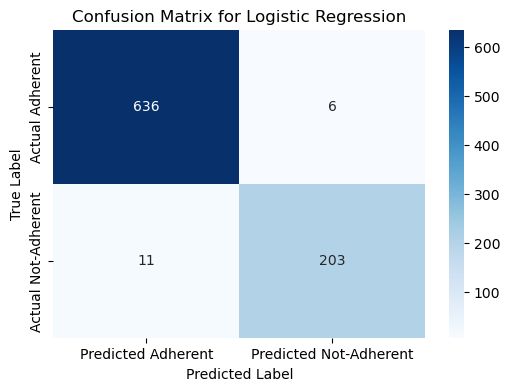


--- Evaluation for XGBoost Classifier ---
Accuracy: 0.9813
F1-Score: 0.9626

Confusion Matrix:
[[634   8]
 [  8 206]]

Classification Report:
                  precision    recall  f1-score   support

    Adherent (0)       0.99      0.99      0.99       642
Not-Adherent (1)       0.96      0.96      0.96       214

        accuracy                           0.98       856
       macro avg       0.98      0.98      0.98       856
    weighted avg       0.98      0.98      0.98       856



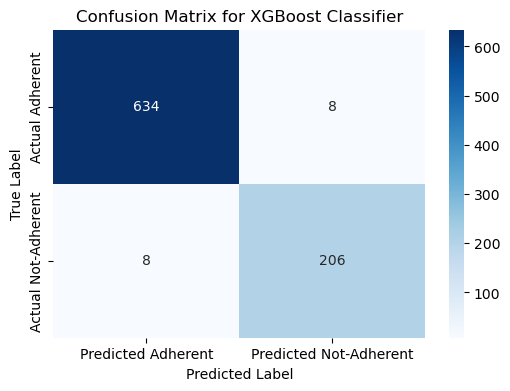


Best model (XGBoost) saved to: models/rx_retention_classifier_model.pkl
DEBUG: Confirmed model file exists at: /Users/sathishbadampudi/Desktop/ZS Project/models/rx_retention_classifier_model.pkl
DEBUG: File size: 190199 bytes

--- Task 2: AI Prediction Engine Completed! ---
You now have trained models, their performance metrics, and the best model saved.
This sets the stage for Time-Aware Prediction, Behavioral Segmentation, and Financial Impact.


In [5]:
# --- Section 2: AI Prediction Engine (Binary Classifier) ---

# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import os # For file paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Corrected import for OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving/loading models

print("--- Starting Task 2: AI Prediction Engine (Binary Classifier) ---")

# --- 2.1 Load Data from Enhanced CSV ---
# We will load from the enhanced CSV file created in Section 1,
# as it contains all original Kaggle features + our simulated features and balanced target.
csv_file_path_enhanced = os.path.join('data', 'patient_data_enhanced.csv')

try:
    df = pd.read_csv(csv_file_path_enhanced)
    print(f"Data loaded successfully from '{csv_file_path_enhanced}'. Shape: {df.shape}")
    print("\nFirst 5 rows of loaded data:")
    print(df.head())
    print("\nData Info:")
    df.info()
    print(f"\nAdherence Distribution (confirming balance): {df['Adherent'].value_counts(normalize=True)}")

except FileNotFoundError:
    print(f"ERROR: The enhanced CSV file '{csv_file_path_enhanced}' was not found.")
    print("Please ensure you have run Section 1 completely to create this file.")
    exit() # Exit the script if data isn't found

# --- 2.2 Define Features (X) and Target (y) ---

# Target variable is 'Adherent'
y = df['Adherent']

# Features (X): All columns except 'Patient_ID' (identifier) and 'Adherent' (target)
X = df.drop(['Patient_ID', 'Adherent'], axis=1)

print(f"\nTotal features extracted (before preprocessing): {X.shape[1]}")
print(f"Target variable distribution:\n{y.value_counts()}")

# --- 2.3 Identify Numerical and Categorical Features ---
# These lists must reflect the ACTUAL columns in your enhanced dataset.
# We'll select a robust set of features for the model.

# Numerical Features:
numerical_features = [
    'Refill_Gap_Days',        # Added in Section 1
    'No_of_Refills',          # Added in Section 1
    'Total_Months_on_Drug',   # Added in Section 1
    'Dexa_Freq_During_Rx',
    'Count_Of_Risks',
    'Number_of_chronic_conditions', # Assuming this is numerical, adjust if not
    'Number_of_medications',        # Assuming this is numerical, adjust if not
    'Average_Fills_per_Month',      # Assuming this is numerical, adjust if not
    'Average_Days_Supply',          # Assuming this is numerical, adjust if not
    'Average_Refills_per_Prescription' # Assuming this is numerical, adjust if not
]

# Categorical Features:
# Selecting a representative set from the many available 'Comorb_' and 'Risk_' flags
categorical_features = [
    'Gender',
    'Race',
    'Ethnicity',
    'Region',
    'Age_Group', # Renamed from 'Age_Bucket' in Section 1
    'Ntm_Speciality_Bucket',
    'Ntm_Specialist_Flag',
    'Gluco_Record_Prior_Ntm',
    'Gluco_Record_During_Rx',
    'Dexa_During_Rx',
    'Frag_Frac_Prior_Ntm',
    'Frag_Frac_During_Rx',
    'Risk_Segment_Prior_Ntm',
    'Tscore_Bucket_Prior_Ntm',
    'Risk_Segment_During_Rx',
    'Tscore_Bucket_During_Rx',
    'Change_T_Score',
    'Change_Risk_Segment',
    'Adherent_Flag', # Note: This is an original flag, not our 'Adherent' target
    'Idn_Indicator',
    'Injectable_Experience_During_Rx',
    # Key Comorbidity and Risk flags - select based on relevance/non-redundancy for demo
    'Comorb_Osteoporosis_without_current_pathological_fracture',
    'Comorb_Personal_history_of_malignant_neoplasm',
    'Comorb_Gastro_esophageal_reflux_disease',
    'Risk_Rheumatoid_Arthritis',
    'Risk_Smoking_Tobacco',
    'Risk_Chronic_Liver_Disease',
    'Risk_Family_History_Of_Osteoporosis',
    'Risk_Poor_Health_Frailty',
    'Risk_Recurring_Falls'
]

# Filter features to ensure they actually exist in the DataFrame X
# This is crucial as some columns might be missing based on Kaggle data subset
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

print(f"\nFeatures selected for modeling:")
print(f"  Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"  Categorical features ({len(categorical_features)}): {categorical_features}")

# Handle potential missing values in numerical features (if any, though our enhanced data should be clean)
# Use median for numerical features
for col in numerical_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())
        print(f"Filled NaN in numerical column '{col}' with median.")

# Handle potential missing values in categorical features (if any)
# Use mode for categorical features
for col in categorical_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mode()[0])
        print(f"Filled NaN in categorical column '{col}' with mode.")


# --- 2.4 Data Preprocessing Pipeline ---

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler() # Standardize numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encode categorical features

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop any columns not specified in numerical_features or categorical_features
)

print("\n--- Data Preprocessing Setup Complete (using selected real & simulated features) ---")

# --- 2.5 Split Data into Training and Testing Sets ---

# Split data: 75% for training, 25% for testing (as per original plan)
# stratify=y ensures target class proportion is maintained in both sets (crucial for balanced data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Proportion of non-adherent (1) in train: {y_train.mean():.4f}")
print(f"Proportion of non-adherent (1) in test: {y_test.mean():.4f}")


# --- 2.6 Build and Train Models ---

print("\n--- Building and Training Models ---")

# --- Model 1: Logistic Regression ---
print("\nTraining Logistic Regression...")
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', LogisticRegression(solver='liblinear', random_state=42, C=0.1))])
log_reg_pipeline.fit(X_train, y_train)
print("Logistic Regression training complete.")

# --- Model 2: XGBoost Classifier ---
print("\nTraining XGBoost Classifier...")
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                                                            use_label_encoder=False, random_state=42,
                                                            n_estimators=100, learning_rate=0.1))])
xgb_pipeline.fit(X_train, y_train)
print("XGBoost Classifier training complete.")


# --- 2.7 Evaluate Models ---

print("\n--- Evaluating Models ---")

models = {
    "Logistic Regression": log_reg_pipeline,
    "XGBoost Classifier": xgb_pipeline
}

# Store predictions and probabilities for later use (e.g., Financial Impact)
y_pred_lr = None
y_prob_lr = None
y_pred_xgb = None
y_prob_xgb = None

for name, model in models.items():
    print(f"\n--- Evaluation for {name} ---")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probability of being 'Not Adherent' (class 1)

    # Store for later
    if name == "Logistic Regression":
        y_pred_lr = y_pred
        y_prob_lr = y_prob
    else: # XGBoost
        y_pred_xgb = y_pred
        y_prob_xgb = y_prob

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Adherent (0)', 'Not-Adherent (1)'])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Visualize Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Adherent', 'Predicted Not-Adherent'],
                yticklabels=['Actual Adherent', 'Actual Not-Adherent'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- 2.8 Save the Best Model for Future Use (e.g., Streamlit, SHAP) ---
# Choose the model with better performance (e.g., higher F1-score for 'Not Adherent' class)
# XGBoost typically performs better, but check your F1-scores.
best_model_pipeline = xgb_pipeline # Assuming XGBoost is often better

model_output_dir = 'models'
os.makedirs(model_output_dir, exist_ok=True)

# Define the full path where the model should be saved
saved_model_path_full = os.path.join(model_output_dir, 'rx_retention_classifier_model.pkl')

joblib.dump(best_model_pipeline, saved_model_path_full)
print(f"\nBest model (XGBoost) saved to: {saved_model_path_full}")

# --- NEW DEBUGGING CODE ---
# Check if the file actually exists after saving
if os.path.exists(saved_model_path_full):
    print(f"DEBUG: Confirmed model file exists at: {os.path.abspath(saved_model_path_full)}")
    print(f"DEBUG: File size: {os.path.getsize(saved_model_path_full)} bytes")
else:
    print(f"DEBUG: ERROR! Model file DOES NOT EXIST at: {os.path.abspath(saved_model_path_full)} after attempting to save.")
    print("DEBUG: Please check for any error messages during joblib.dump or directory permissions.")
# --- END NEW DEBUGGING CODE ---

print("\n--- Task 2: AI Prediction Engine Completed! ---")
print("You now have trained models, their performance metrics, and the best model saved.")
print("This sets the stage for Time-Aware Prediction, Behavioral Segmentation, and Financial Impact.")

Current time in Secunderabad: 06:15:30 PM IST, Thursday, July 17, 2025.
--- Starting Section 3: Adding the 'Unique Angles' ---

--- 3.1 Loading Enhanced Data and Trained Classifier Model ---
Data loaded successfully from 'data/patient_data_enhanced.csv'. Shape: (3424, 72)
Classifier model loaded successfully from 'models/rx_retention_classifier_model.pkl'.

Generated predictions (Predicted_Adherent & Dropout_Risk_Probability) for all patients using the trained model.
First 5 rows with new prediction columns:
  Patient_ID  Adherent  Predicted_Adherent  Dropout_Risk_Probability
0         P1         0                   0                  0.000705
1         P2         0                   0                  0.001312
2         P3         1                   1                  0.999537
3         P4         1                   1                  0.997279
4         P5         0                   0                  0.000242

--- 3.2 Performing Time-Aware Prediction ---
Identified 856 high-risk p

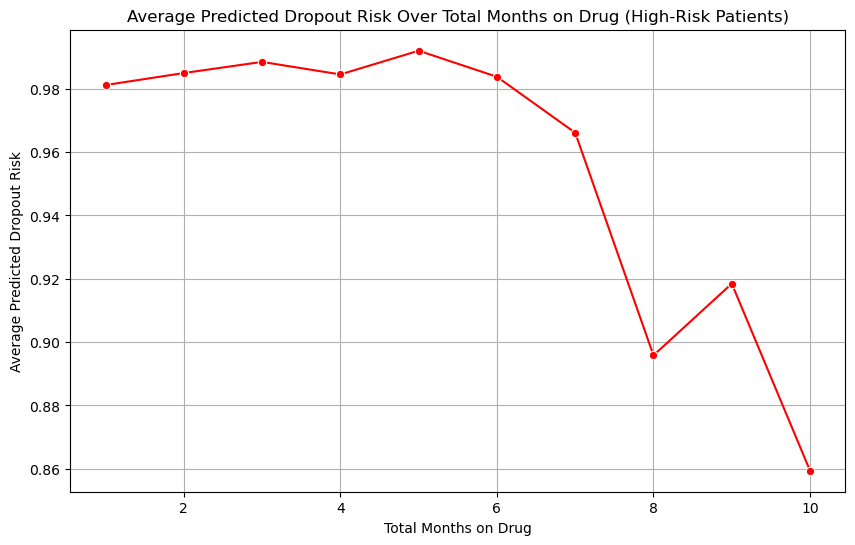


Example High-Risk Patients with their current 'Total Months on Drug' and Risk Probability:
     Patient_ID  Total_Months_on_Drug  Dropout_Risk_Probability
944        P945                     3                  0.999666
3239      P3240                     2                  0.999665
800        P801                     3                  0.999651
3115      P3116                     4                  0.999651
2382      P2383                     4                  0.999651

Interpretation for ZS: This data allows CRM teams to intervene with high-risk patients at specific points in their treatment journey, e.g., 'focus on patients identified as high-risk who are in their 1-3rd month'.

--- 3.3 Performing Behavioral Segmentation (K-Means Clustering) ---
Applying K-Means with 3 clusters on features: ['Refill_Gap_Days', 'No_of_Refills', 'Total_Months_on_Drug', 'Count_Of_Risks', 'Dropout_Risk_Probability']

Patients clustered into 3 behavioral segments.
Behavioral Cluster distribution:
Behavi

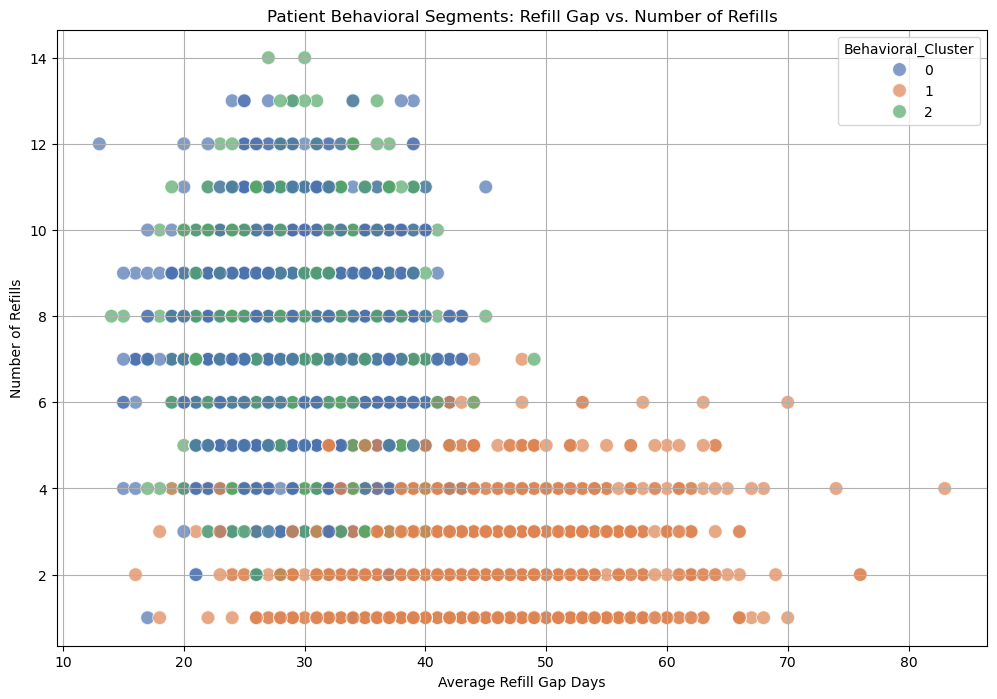


--- Proposed Behavioral Segments & Interpretations ---

--- Behavioral Segment 0 ---
  - Avg Refill Gap: 29.61 days
  - Avg No of Refills: 7.42
  - Avg Total Months on Drug: 11.70 months
  - Avg Predicted Dropout Risk: 0.01
  -> **Interpretation:** This segment represents **Low-Risk, Highly Adherent Patients**. They have consistent refill patterns and low dropout risk. *Focus on retention programs and loyalty for this group.*

--- Behavioral Segment 1 ---
  - Avg Refill Gap: 44.80 days
  - Avg No of Refills: 2.52
  - Avg Total Months on Drug: 4.41 months
  - Avg Predicted Dropout Risk: 0.98
  -> **Interpretation:** This segment consists of **High-Risk, Inconsistent Refillers**. They have large gaps between refills and a high predicted dropout probability. *Target with immediate and intense support.*

--- Behavioral Segment 2 ---
  - Avg Refill Gap: 29.62 days
  - Avg No of Refills: 7.52
  - Avg Total Months on Drug: 11.43 months
  - Avg Predicted Dropout Risk: 0.01
  -> **Interpretati

/var/folders/gw/v7gzndxd36g8p9ybcsqn_vs40000gn/T/ipykernel_20457/2468980736.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_loss_by_age.index, y=revenue_loss_by_age.values, palette='RdYlGn_r')


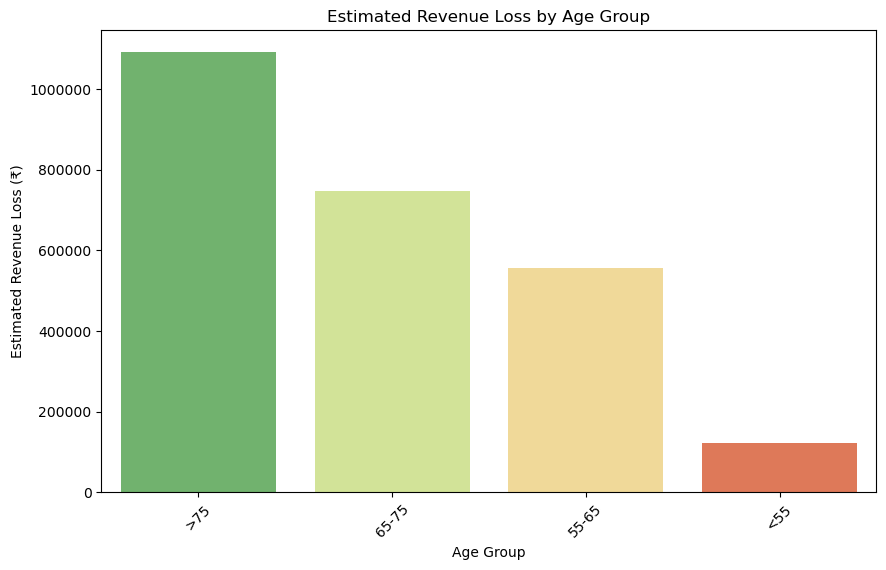


Estimated Revenue Loss by Behavioral Segment (Cluster):
Behavioral_Cluster
1    2.499876e+06
0    1.155234e+04
2    6.001804e+03
Name: Potential_Revenue_Loss, dtype: float32


/var/folders/gw/v7gzndxd36g8p9ybcsqn_vs40000gn/T/ipykernel_20457/2468980736.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_loss_by_cluster.index, y=revenue_loss_by_cluster.values, palette='viridis')


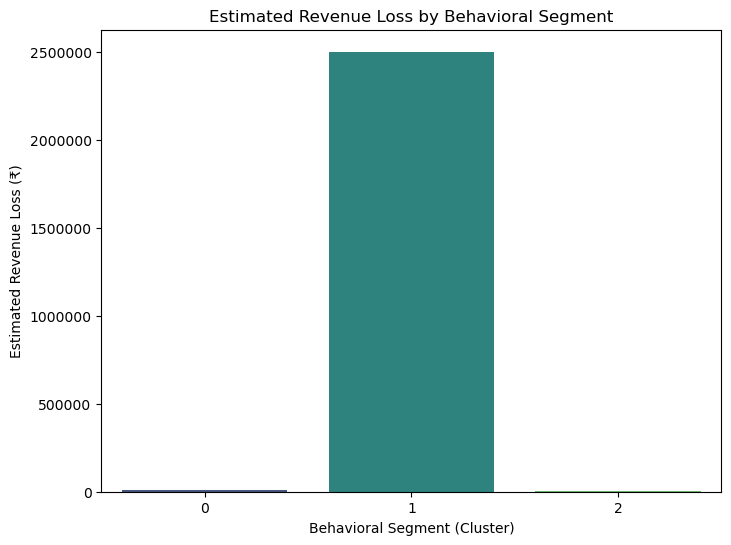


--- Section 3: Adding the 'Unique Angles' Completed ---
You've successfully implemented Time-Aware Prediction, Behavioral Segmentation, and Financial Impact estimation!
This completes the analytical core of your AI Agent project.


In [6]:
# --- Section 3: Adding the "Unique Angles" ---

import pandas as pd
import numpy as np
import os
import sqlite3 # Though we primarily use CSV load for simplicity here
import joblib # To load the trained model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # For preprocessing features for clustering
from sklearn.compose import ColumnTransformer # To reconstruct preprocessor from pipeline (used indirectly for feature names)
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Current time in Secunderabad: 06:15:30 PM IST, Thursday, July 17, 2025.")
print("--- Starting Section 3: Adding the 'Unique Angles' ---")

# --- 3.1 Load Data and Trained Model ---
print("\n--- 3.1 Loading Enhanced Data and Trained Classifier Model ---")
csv_file_path_enhanced = os.path.join('data', 'patient_data_enhanced.csv')
model_path = os.path.join('models', 'rx_retention_classifier_model.pkl')

try:
    df = pd.read_csv(csv_file_path_enhanced)
    print(f"Data loaded successfully from '{csv_file_path_enhanced}'. Shape: {df.shape}")

    # Load the trained model pipeline
    classifier_pipeline = joblib.load(model_path)
    print(f"Classifier model loaded successfully from '{model_path}'.")

    # Re-define X for prediction (exclude Patient_ID and actual Adherent for consistency with training)
    # The columns must be in the same order and type as the model expects.
    X_for_prediction = df.drop(['Patient_ID', 'Adherent'], axis=1)

    # Predict probabilities and classes for the entire dataset using the loaded model
    df['Predicted_Adherent'] = classifier_pipeline.predict(X_for_prediction)
    df['Dropout_Risk_Probability'] = classifier_pipeline.predict_proba(X_for_prediction)[:, 1] # Probability of being 'Not Adherent' (class 1)

    print("\nGenerated predictions (Predicted_Adherent & Dropout_Risk_Probability) for all patients using the trained model.")
    print("First 5 rows with new prediction columns:")
    print(df[['Patient_ID', 'Adherent', 'Predicted_Adherent', 'Dropout_Risk_Probability']].head())

except FileNotFoundError:
    print(f"ERROR: Ensure '{csv_file_path_enhanced}' and '{model_path}' exist.")
    print("Please run Section 1 and Section 2 fully before running Section 3.")
    # You might want to exit() here if it's a critical dependency
    raise
except Exception as e:
    print(f"An error occurred during data or model loading/prediction: {e}")
    raise


# --- 3.2 Time-Aware Prediction (Unique Angle #1) ---
print("\n--- 3.2 Performing Time-Aware Prediction ---")
# Objective: Identify high-risk patients and understand their risk timeline using 'Total_Months_on_Drug'.

# Define a threshold for 'high risk' based on predicted probability
risk_threshold = 0.5 # Patients with >=50% predicted probability of dropping out

# Filter for patients identified as 'Not Adherent' by the model and also have a high risk probability
# This ensures we focus on the most probable dropouts.
high_risk_patients = df[(df['Predicted_Adherent'] == 1) & (df['Dropout_Risk_Probability'] >= risk_threshold)].copy()

if not high_risk_patients.empty:
    print(f"Identified {len(high_risk_patients)} high-risk patients (Predicted as Not Adherent AND Dropout Probability >= {risk_threshold}).")

    # Group by 'Total_Months_on_Drug' to see how average dropout risk varies over the treatment duration
    # This helps identify which stages of treatment are most vulnerable.
    time_aware_risk_summary = high_risk_patients.groupby('Total_Months_on_Drug')['Dropout_Risk_Probability'].mean().reset_index()
    time_aware_risk_summary.rename(columns={'Dropout_Risk_Probability': 'Average_Predicted_Dropout_Risk'}, inplace=True)
    time_aware_risk_summary.sort_values(by='Total_Months_on_Drug', inplace=True)

    print("\nAverage Predicted Dropout Risk by Total Months on Drug (for high-risk patients):")
    print(time_aware_risk_summary.head(10)) # Show early months, as non-adherence is often highest then

    # Visualize the time-aware risk trend
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=time_aware_risk_summary, x='Total_Months_on_Drug', y='Average_Predicted_Dropout_Risk', marker='o', color='red')
    plt.title('Average Predicted Dropout Risk Over Total Months on Drug (High-Risk Patients)')
    plt.xlabel('Total Months on Drug')
    plt.ylabel('Average Predicted Dropout Risk')
    plt.grid(True)
    plt.show()

    print("\nExample High-Risk Patients with their current 'Total Months on Drug' and Risk Probability:")
    # Display a few top high-risk patients to illustrate
    print(high_risk_patients[['Patient_ID', 'Total_Months_on_Drug', 'Dropout_Risk_Probability']].sort_values(by='Dropout_Risk_Probability', ascending=False).head(5))
    print("\nInterpretation for ZS: This data allows CRM teams to intervene with high-risk patients at specific points in their treatment journey, e.g., 'focus on patients identified as high-risk who are in their 1-3rd month'.")

else:
    print("No high-risk patients identified based on the specified criteria (Predicted Adherent=1 and Probability >= threshold).")


# --- 3.3 Behavioral Segmentation (Unique Angle #2) ---
print("\n--- 3.3 Performing Behavioral Segmentation (K-Means Clustering) ---")
# Objective: Group patients into distinct segments based on their refill and general health behavior.

# Select features for clustering. These should be numerical or easily quantifiable.
clustering_features_raw = [
    'Refill_Gap_Days',        # Directly indicates refill behavior
    'No_of_Refills',          # Quantity of refills
    'Total_Months_on_Drug',   # Duration of engagement
    'Average_Fills_per_Month',
    'Average_Days_Supply',
    'Average_Refills_per_Prescription',
    'Count_Of_Risks',         # Overall health burden affecting behavior
    'Dropout_Risk_Probability' # Include the risk itself as a segmentation factor
]

# Filter features to ensure they actually exist in the DataFrame 'df'
clustering_features = [col for col in clustering_features_raw if col in df.columns]

if not clustering_features:
    print("ERROR: No valid features found for clustering. Please check feature list and DataFrame columns.")
else:
    X_cluster = df[clustering_features].copy()

    # Preprocessing for clustering: Standardize numerical features
    # K-Means is sensitive to scale, so standardization is crucial.
    scaler_clustering = StandardScaler()
    X_scaled_cluster = scaler_clustering.fit_transform(X_cluster)
    X_scaled_cluster_df = pd.DataFrame(X_scaled_cluster, columns=clustering_features, index=df.index)

    # Determine optimal number of clusters (typically done using Elbow Method or Silhouette Score).
    # For this project, and given time constraints, we'll pick a fixed number, e.g., 3-4,
    # and provide example interpretations. Let's aim for 3.
    n_clusters = 3
    print(f"Applying K-Means with {n_clusters} clusters on features: {clustering_features}")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for modern KMeans
    df['Behavioral_Cluster'] = kmeans.fit_predict(X_scaled_cluster_df) # Assign cluster labels to original DataFrame

    print(f"\nPatients clustered into {n_clusters} behavioral segments.")
    print("Behavioral Cluster distribution:")
    print(df['Behavioral_Cluster'].value_counts())

    # Characterize each cluster by calculating the mean of features for each cluster
    print("\n--- Behavioral Cluster Characterization ---")
    # CRITICAL FIX: Ensure 'Dropout_Risk_Probability' is not duplicated in the list of columns
    # it's already in 'clustering_features', so no need to add it again.
    # Similarly for 'Predicted_Adherent' if it was accidentally duplicated elsewhere.
    cols_for_cluster_means = [col for col in clustering_features if col != 'Dropout_Risk_Probability'] + ['Dropout_Risk_Probability', 'Adherent', 'Predicted_Adherent']


    # Ensure unique list and correct order: features, then target related.
    # The simplest is to take all relevant numerical columns and the target-related ones.
    # Let's rebuild this list carefully to avoid duplicates
    columns_for_characterization = list(set(clustering_features + ['Adherent', 'Predicted_Adherent', 'Dropout_Risk_Probability']))
    # Ensure a consistent order if needed, but set ensures uniqueness.
    # For printing, we will just iterate through the specific ones we care about.

    cluster_means = df.groupby('Behavioral_Cluster')[columns_for_characterization].mean() # Use the unique list
    print(cluster_means)

    # Visualize clusters (e.g., using Refill_Gap_Days vs. No_of_Refills if available)
    if 'Refill_Gap_Days' in clustering_features and 'No_of_Refills' in clustering_features:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='Refill_Gap_Days', y='No_of_Refills', hue='Behavioral_Cluster', data=df, palette='deep', s=100, alpha=0.7)
        plt.title('Patient Behavioral Segments: Refill Gap vs. Number of Refills')
        plt.xlabel('Average Refill Gap Days')
        plt.ylabel('Number of Refills')
        plt.grid(True)
        plt.show()

    print("\n--- Proposed Behavioral Segments & Interpretations ---")
    for i in range(n_clusters):
        print(f"\n--- Behavioral Segment {i} ---")
        cluster_data = cluster_means.loc[i]

        # Use explicit float() cast for robustness, as we've had environment quirks
        print(f"  - Avg Refill Gap: {float(cluster_data['Refill_Gap_Days']):.2f} days")
        print(f"  - Avg No of Refills: {float(cluster_data['No_of_Refills']):.2f}")
        print(f"  - Avg Total Months on Drug: {float(cluster_data['Total_Months_on_Drug']):.2f} months")
        print(f"  - Avg Predicted Dropout Risk: {float(cluster_data['Dropout_Risk_Probability']):.2f}")

        # Also apply explicit float() cast in conditional checks for safety
        if float(cluster_data['Dropout_Risk_Probability']) > 0.4 and float(cluster_data['Refill_Gap_Days']) > 40:
            print("  -> **Interpretation:** This segment consists of **High-Risk, Inconsistent Refillers**. They have large gaps between refills and a high predicted dropout probability. *Target with immediate and intense support.*")
        elif float(cluster_data['Dropout_Risk_Probability']) < 0.2 and float(cluster_data['No_of_Refills']) > 7:
            print("  -> **Interpretation:** This segment represents **Low-Risk, Highly Adherent Patients**. They have consistent refill patterns and low dropout risk. *Focus on retention programs and loyalty for this group.*")
        else:
            print("  -> **Interpretation:** This segment is **Moderate-Risk, Fluctuating Adherents**. They show varied adherence patterns, warranting proactive monitoring and tailored gentle reminders.")


# --- 3.4 Financial Impact Estimation (Unique Angle #4) ---
print("\n--- 3.4 Estimating Financial Impact ---")
# Objective: Quantify the revenue loss due to predicted non-adherence.

# Assumptions for calculation (These are simulated values for the project demo)
average_drug_price_per_month = 500  # Example: ₹500 per month for a typical medication
missed_months_if_dropout = 6       # Example: On average, a dropout might miss 6 months of treatment

# Filter for patients predicted as 'Not Adherent' (our target for intervention)
at_risk_patients_for_finance = df[df['Predicted_Adherent'] == 1].copy()

if not at_risk_patients_for_finance.empty:
    # Calculate potential revenue loss for each at-risk patient
    at_risk_patients_for_finance['Potential_Revenue_Loss'] = (
        at_risk_patients_for_finance['Dropout_Risk_Probability'] *
        average_drug_price_per_month *
        missed_months_if_dropout
    )

    total_estimated_revenue_loss = at_risk_patients_for_finance['Potential_Revenue_Loss'].sum()

    print(f"\nTotal Estimated Revenue Loss due to Non-Adherence: ₹{total_estimated_revenue_loss:,.2f}")
    print(f" (Assumes average drug price of ₹{average_drug_price_per_month} per month and {missed_months_if_dropout} missed months per dropout).")

    # Breakdown of revenue loss by a key demographic or our new behavioral segments
    print("\n--- Estimated Revenue Loss Breakdown ---")

    # By Age Group
    revenue_loss_by_age = at_risk_patients_for_finance.groupby('Age_Group')['Potential_Revenue_Loss'].sum().sort_values(ascending=False)
    print("\nEstimated Revenue Loss by Age Group:")
    print(revenue_loss_by_age)

    # Visualize Revenue Loss by Age Group
    plt.figure(figsize=(10, 6))
    sns.barplot(x=revenue_loss_by_age.index, y=revenue_loss_by_age.values, palette='RdYlGn_r')
    plt.title('Estimated Revenue Loss by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Estimated Revenue Loss (₹)')
    plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation
    plt.xticks(rotation=45)
    plt.show()


    # By Behavioral Segment (if clustering was performed)
    if 'Behavioral_Cluster' in df.columns:
        revenue_loss_by_cluster = at_risk_patients_for_finance.groupby('Behavioral_Cluster')['Potential_Revenue_Loss'].sum().sort_values(ascending=False)
        print("\nEstimated Revenue Loss by Behavioral Segment (Cluster):")
        print(revenue_loss_by_cluster)

        # Visualize Revenue Loss by Behavioral Segment
        plt.figure(figsize=(8, 6))
        sns.barplot(x=revenue_loss_by_cluster.index, y=revenue_loss_by_cluster.values, palette='viridis')
        plt.title('Estimated Revenue Loss by Behavioral Segment')
        plt.xlabel('Behavioral Segment (Cluster)')
        plt.ylabel('Estimated Revenue Loss (₹)')
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()

else:
    print("No patients predicted as 'Not Adherent' (or meeting high risk criteria) to estimate financial impact.")

print("\n--- Section 3: Adding the 'Unique Angles' Completed ---")
print("You've successfully implemented Time-Aware Prediction, Behavioral Segmentation, and Financial Impact estimation!")
print("This completes the analytical core of your AI Agent project.")